In [48]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 
import cv2

def imread(filename):
    return np.array(Image.open(filename)).astype('float')

def imget(filename):
    return Image.open(filename)

def imshow(img):
    plt.imshow(img.astype(np.uint8))

def draw_mask(img, points, alpha=0.95):
    # mask = np.ones(img.shape) * 255
    mask = np.zeros(img.shape)
    mask[points[:, 1], points[:, 0], :] = (0, 0, 255)
    mask *= alpha
    _img = mask + img
    _img = np.clip(_img, 0, 255)
    imshow(_img)

def pointspooling(points, dowscale=16):
    _points = points.copy()
    _points = _points / dowscale 
    _points = _points.astype("int")
    _points = _points * dowscale 
    return _points 

points_path = "./data/1701153900630209_front_wide.npy"
img_path = "./data/1701153900630209_front_wide_undist.jpg"
points = np.load(points_path)
img = imread(img_path)
print(img.shape, points[:, 0].max(), points[:, 1].max())
x, y = points[:, 1], points[:, 0]

(2160, 3840, 3) 3839 2159


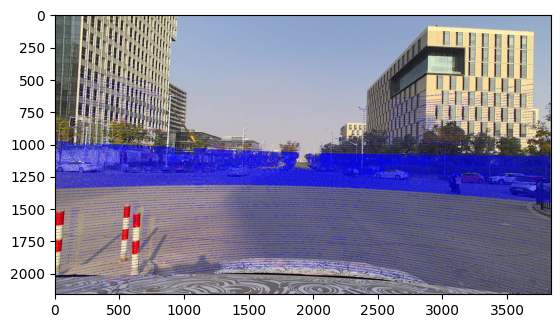

In [49]:
img = imread(img_path)
points = pointspooling(points.copy(), dowscale=1)
for p in points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (0, 0, 255), 1)
# points.shape
imshow(img)

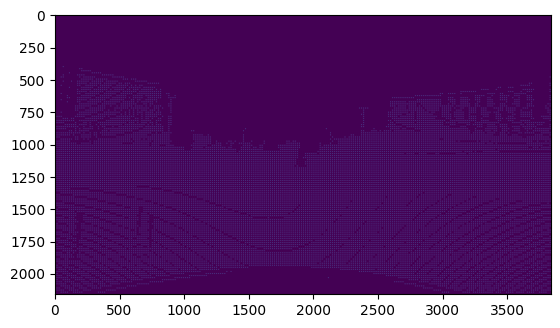

In [32]:
from typing import Any
import torch 
from torch.nn import Conv2d 


def scatter(points, img):
    x, y = points[:, 1], points[:, 0]
    mask = np.zeros(img.shape[:2])
    mask[x, y] = 1
    return torch.from_numpy(mask).float()

def conv_block(kernel_size=3, dilation=2):
    padding = kernel_size // 2 
    conv = Conv2d(in_channels=1, out_channels=1,
                     kernel_size=kernel_size,
                       padding=padding,
                       stride=1,
                       bias=False,
                       dilation=dilation)
    conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
    # conv.bias = torch.nn.Parameter(torch.zeros_like(conv.bias))
    conv.eval()
    return conv

class PointNMS(object):
    """ 
        use dilation conv to do point nms
    """
    def __init__(self, kernel_size=3, dilation=5) -> None:
        self.conv = conv_block(kernel_size=kernel_size, dilation=dilation)
    
    @torch.inference_mode()
    def __call__(self, points, img) -> Any:
        assert isinstance(points, np.ndarray)
        mask = scatter(points, img)
        mask = self.conv(mask[None, None, :, :])[0][0]
        return (mask > 0).cpu().numpy().astype("float")
nms = PointNMS(kernel_size=3, dilation=2) 
points = pointspooling(points, dowscale=1)
mask = nms(points, img)
imshow(mask)

In [7]:
img = imread(img_path)
img.shape

(2160, 3840, 3)

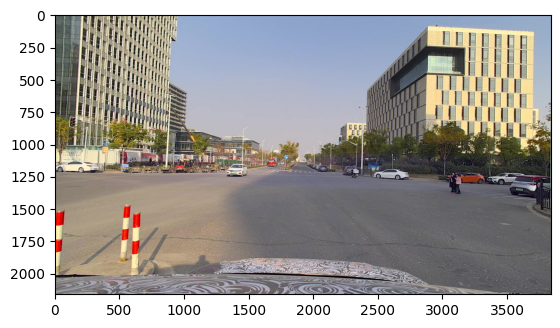

In [5]:

draw_mask(img, points)
image = img.astype('uint8')

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/root/yunzhi/checkpoint/sam/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:2"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [8]:
predictor.set_image(image)

In [11]:
input_point = points    # in [h, w] format
input_label = np.ones(points.shape[0])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 697.00 GiB (GPU 2; 23.70 GiB total capacity; 3.21 GiB already allocated; 18.92 GiB free; 3.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
# input_point.shape

NameError: name 'input_point' is not defined

In [12]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

127
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


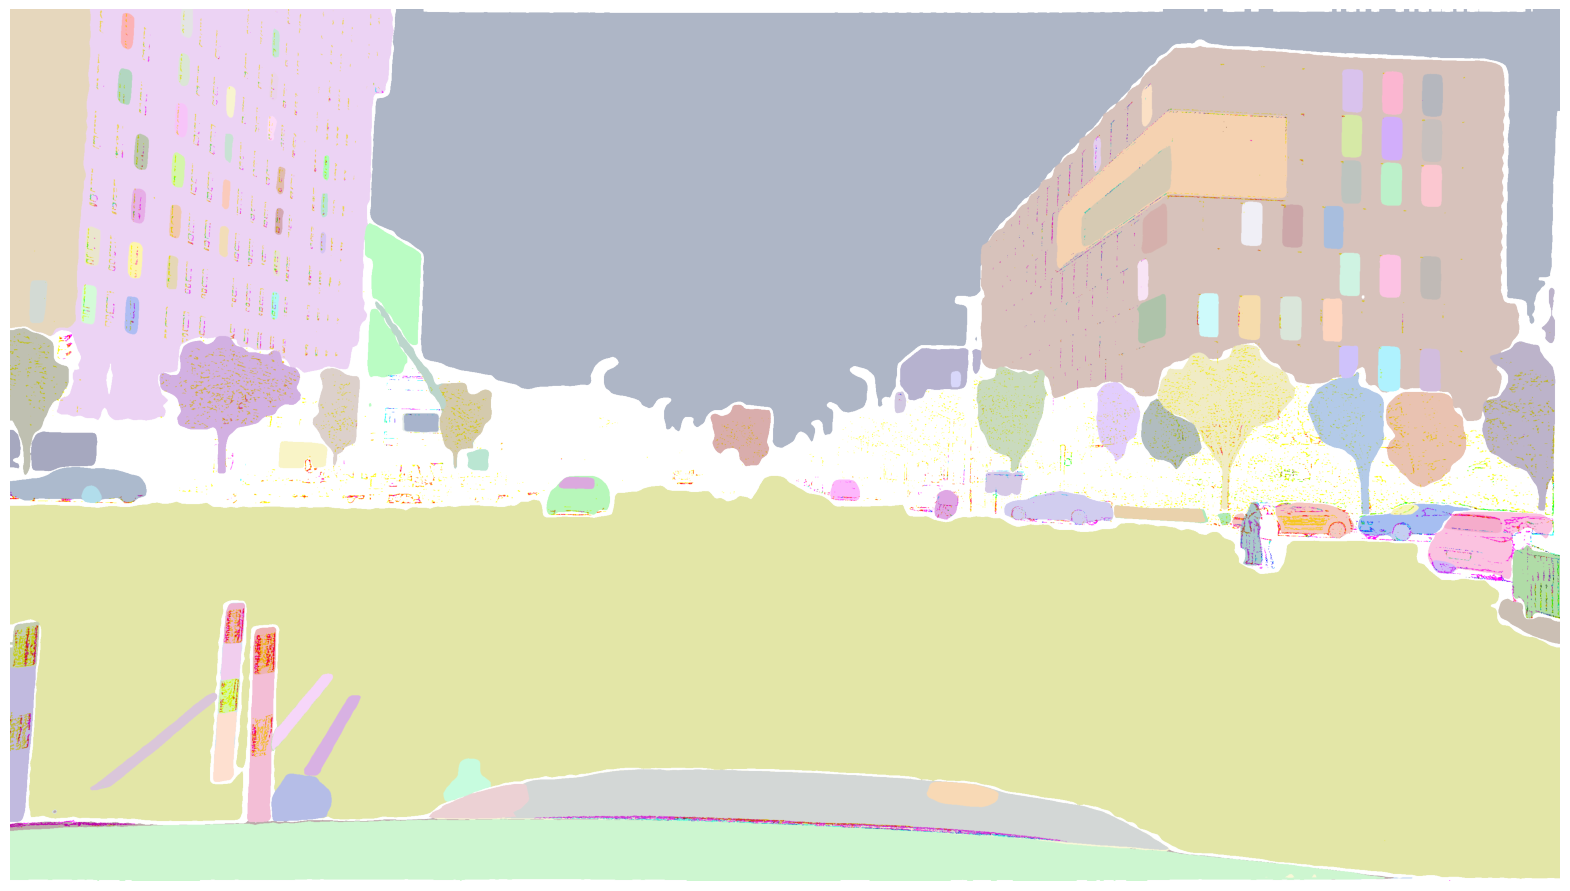

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show() 